# Phân tích cảm xúc dựa trên đánh giá - Nhóm 5

### 

### Kiểm tra và sử dụng GPU

In [3]:
print("HELLO")

HELLO


In [5]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: True
GPU name: NVIDIA GeForce RTX 4060


### Tiền xử lý và chuẩn bị dữ liệu huấn luyện

Quy trình xử lý dữ liệu sẽ được chia thành các bước rõ ràng như sau:

1. **Nạp dữ liệu IMDB**: Sử dụng thư viện `datasets` để tải tập dữ liệu IMDB gồm train và test.
2. **Làm sạch dữ liệu**: Xóa các thẻ HTML, loại bỏ emoji, ký tự đặc biệt, chuẩn hóa khoảng trắng để dữ liệu sạch hơn cho mô hình.
3. **Phân tích, trực quan hóa dữ liệu**: Thống kê, vẽ biểu đồ phân phối cảm xúc, độ dài review, tần suất từ phổ biến, wordcloud...
4. **Chuẩn bị dữ liệu cho BERT**: Tokenize dữ liệu, chuyển đổi về định dạng phù hợp cho mô hình BERT.

Các bước này giúp đảm bảo dữ liệu đầu vào chất lượng, hỗ trợ mô hình học tốt hơn.

#### Bước 1: Nạp dữ liệu IMDB

- Sử dụng thư viện `datasets` để tải tập dữ liệu IMDB.
- Dữ liệu gồm hai phần: train (huấn luyện) và test (kiểm tra).
- Mỗi phần gồm các review phim và nhãn cảm xúc (0: tiêu cực, 1: tích cực).

In [8]:
from datasets import load_dataset

dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]

Dataset imdb downloaded and prepared to C:\Users\Admin\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 68.18it/s]


#### Bước 2: Làm sạch dữ liệu

- Xóa các thẻ HTML, ký tự đặc biệt, emoji khỏi văn bản.
- Chuẩn hóa khoảng trắng, giúp dữ liệu nhất quán hơn.
- Việc làm sạch giúp mô hình tập trung vào nội dung thực sự của review, tránh nhiễu.

In [9]:
import re
import html
import emoji

def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r'<.*?>', '', text)
    text = emoji.replace_emoji(text, replace='[EMOJI]')
    text = re.sub(r'[^\w\s.,!?\-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_dataset(dataset):
    return dataset.map(lambda x: {'text': clean_text(x['text'])})

train_data = clean_dataset(train_data)
test_data = clean_dataset(test_data)

100%|██████████| 25000/25000 [00:32<00:00, 772.79ex/s]


#### Bước 3: Phân tích và trực quan hóa dữ liệu

- Thống kê phân phối cảm xúc, độ dài review.
- Hiển thị top các từ xuất hiện nhiều nhất bằng biểu đồ cột, biểu đồ tròn và wordcloud.
- Giúp hiểu rõ hơn về đặc trưng dữ liệu trước khi huấn luyện.

### Visualize datasets: Top từ phổ biến trong tập dữ liệu

- Biểu đồ cột: Top 30 từ xuất hiện nhiều nhất
- Biểu đồ tròn: Tỷ lệ các từ phổ biến nhất trong tập train

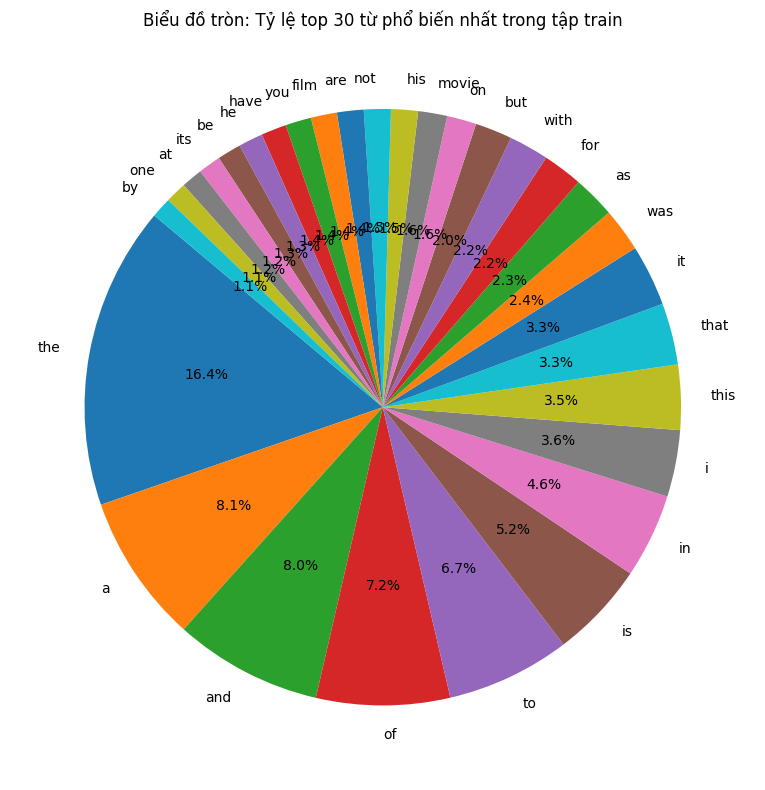

In [10]:

import matplotlib.pyplot as plt
from collections import Counter

all_words = []
for item in train_data:
    all_words.extend(item['text'].lower().split())

word_counts = Counter(all_words)
most_common = word_counts.most_common(30)
words, counts = zip(*most_common)

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=words, autopct='%1.1f%%', startangle=140)
plt.title('Biểu đồ tròn: Tỷ lệ top 30 từ phổ biến nhất trong tập train')
plt.tight_layout()
plt.show()

#### WordCloud: Trực quan hóa các từ phổ biến nhất trong tập train

- WordCloud giúp nhìn nhanh các từ xuất hiện nhiều nhất, từ càng lớn càng xuất hiện nhiều.

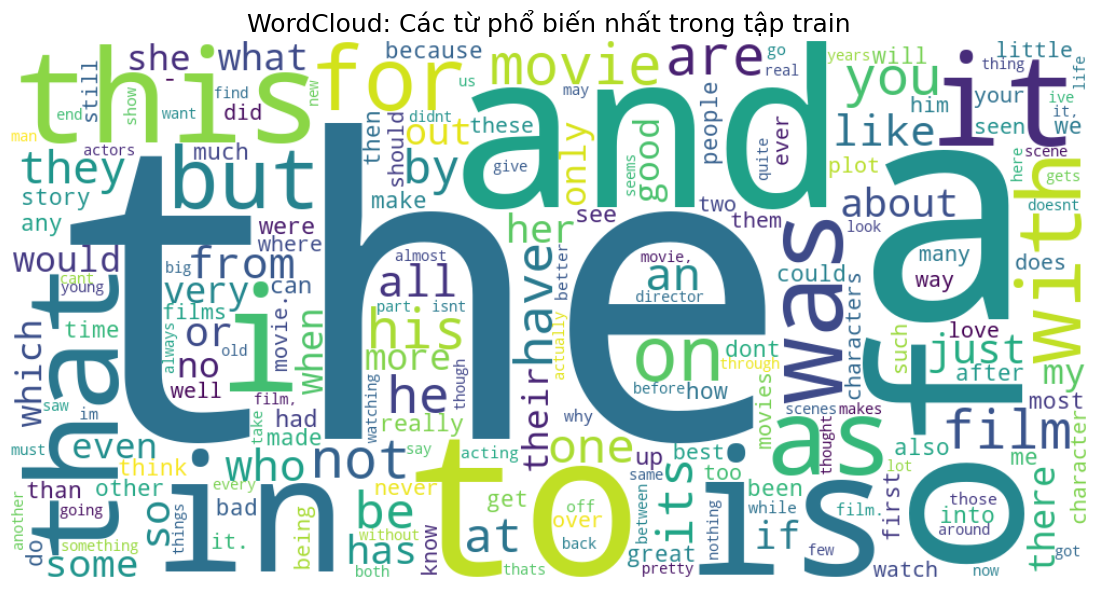

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate_from_frequencies(word_counts)
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud: Các từ phổ biến nhất trong tập train', fontsize=18)
plt.show()

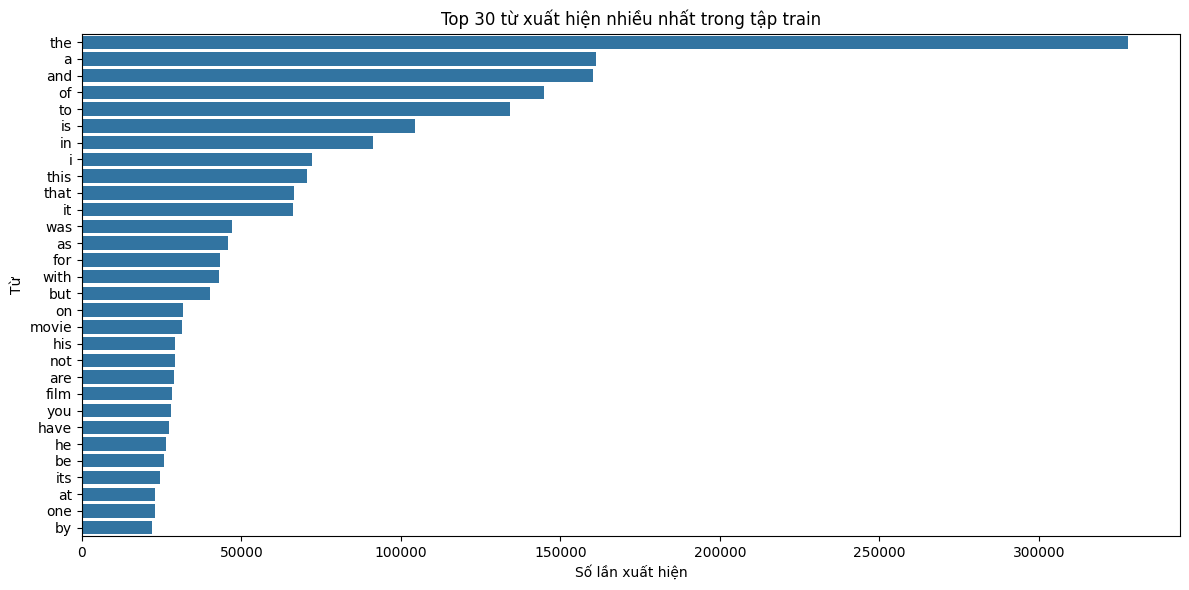

In [12]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), orient='h')
plt.title('Top 30 từ xuất hiện nhiều nhất trong tập train')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Từ')
plt.tight_layout()
plt.show()

### Biểu đồ tổng quan datasets

C:\Users\Admin\AppData\Local\Temp\ipykernel_22908\2588101566.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


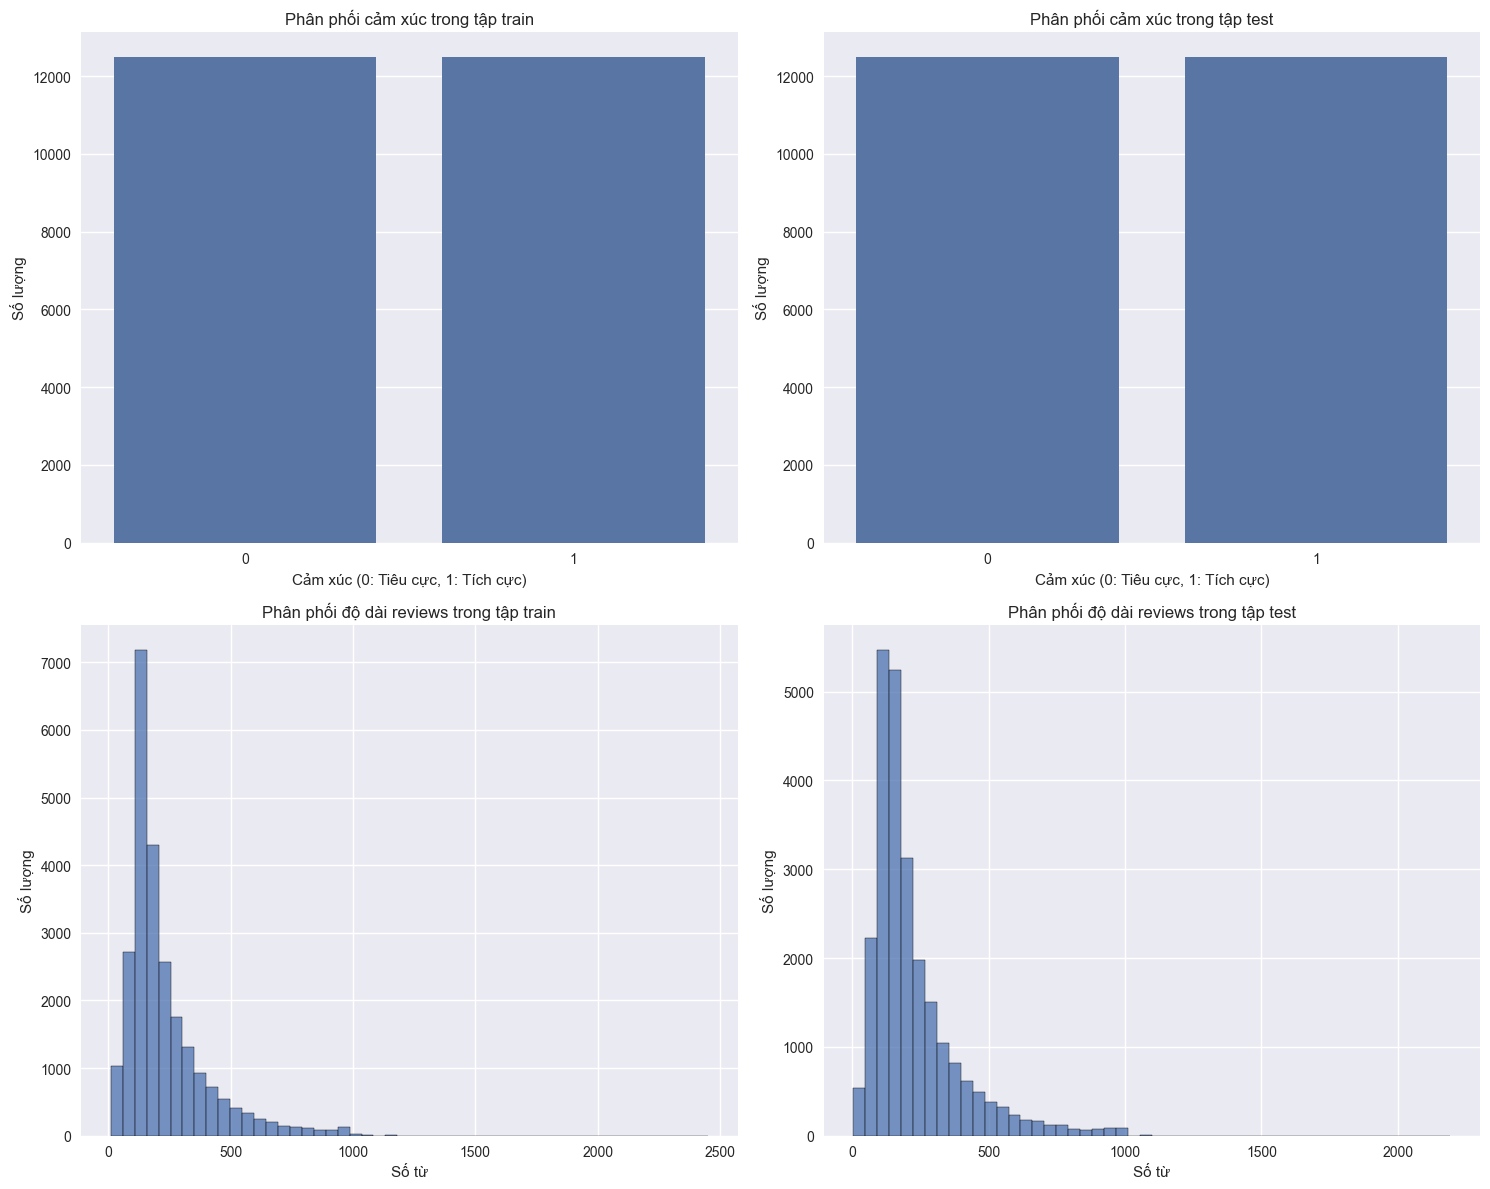


Thống kê cơ bản về độ dài reviews:
Tập train - Trung bình: 229.40 từ, Tối đa: 2450 từ
Tập test - Trung bình: 224.23 từ, Tối đa: 2192 từ

Phân phối cảm xúc:
Tập train - Tiêu cực: 12500, Tích cực: 12500
Tập test - Tiêu cực: 12500, Tích cực: 12500


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn')

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

train_labels = [item['label'] for item in train_data]
test_labels = [item['label'] for item in test_data]

sns.countplot(x=train_labels, ax=axes[0, 0])
axes[0, 0].set_title('Phân phối cảm xúc trong tập train')
axes[0, 0].set_xlabel('Cảm xúc (0: Tiêu cực, 1: Tích cực)')
axes[0, 0].set_ylabel('Số lượng')

sns.countplot(x=test_labels, ax=axes[0, 1])
axes[0, 1].set_title('Phân phối cảm xúc trong tập test')
axes[0, 1].set_xlabel('Cảm xúc (0: Tiêu cực, 1: Tích cực)')
axes[0, 1].set_ylabel('Số lượng')

train_lengths = [len(item['text'].split()) for item in train_data]
test_lengths = [len(item['text'].split()) for item in test_data]

sns.histplot(train_lengths, bins=50, ax=axes[1, 0])
axes[1, 0].set_title('Phân phối độ dài reviews trong tập train')
axes[1, 0].set_xlabel('Số từ')
axes[1, 0].set_ylabel('Số lượng')

sns.histplot(test_lengths, bins=50, ax=axes[1, 1])
axes[1, 1].set_title('Phân phối độ dài reviews trong tập test')
axes[1, 1].set_xlabel('Số từ')
axes[1, 1].set_ylabel('Số lượng')

plt.tight_layout()
plt.show()

print("\nThống kê cơ bản về độ dài reviews:")
print(f"Tập train - Trung bình: {np.mean(train_lengths):.2f} từ, Tối đa: {max(train_lengths)} từ")
print(f"Tập test - Trung bình: {np.mean(test_lengths):.2f} từ, Tối đa: {max(test_lengths)} từ")

print("\nPhân phối cảm xúc:")
print(f"Tập train - Tiêu cực: {train_labels.count(0)}, Tích cực: {train_labels.count(1)}")
print(f"Tập test - Tiêu cực: {test_labels.count(0)}, Tích cực: {test_labels.count(1)}")

## Training data

#### Chuẩn bị dữ liệu cho BERT

Tokenize các review bằng tokenizer của BERT.

Sử dụng tokenizer của mô hình BERT (phiên bản "bert-base-uncased") để chuyển đổi văn bản thành các token số.

In [14]:

from transformers import BertTokenizer # type: ignore

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]


#### Định nghĩa hàm tokenize
> Hàm này nhận vào một batch các review `(examples["text"])`, chuyển thành token, cắt/padding về độ dài 256 token.

In [15]:

def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)


##### Tokenize toàn bộ dữ liệu train và test

Áp dụng hàm `tokenize` cho toàn bộ tập train và test, kết quả là mỗi review sẽ được chuyển thành các trường:
`input_ids`: dãy số đại diện cho các token
`attention_mask`: mặt nạ cho biết token nào là thật, token nào là padding

In [16]:

train_data = train_data.map(tokenize_fn, batched=True)
test_data = test_data.map(tokenize_fn, batched=True)


100%|██████████| 25/25 [01:43<00:00,  4.15s/ba]


###### Định dạng lại dữ liệu cho PyTorch

Chuyển dữ liệu sang định dạng tensor của PyTorch, chỉ giữ lại các trường cần thiết cho huấn luyện: `input_ids`, `attention_mask`, `label`.

In [17]:
train_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])

#### Khởi tạo mô hình BERT cho phân loại

 Sử dụng mô hình BERT đã được pretrain `("bert-base-uncased")`

`num_labels=2`: Bài toán phân loại 2 lớp (tích cực/tiêu cực).

In [18]:


from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Downloading: 100%|██████████| 440M/440M [00:38<00:00, 11.5MB/s] 
c:\Users\Admin\miniconda3\envs\imdb-sentiment2\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\Admin\miniconda3\envs\imdb-sentiment2\lib\site-packag

### Định nghĩa các tham số huấn luyện

`output_dir`: Thư mục lưu model và log.

`evaluation_strategy="epoch"`: Đánh giá trên tập test sau mỗi epoch.

`save_strategy="epoch"`: Lưu model sau mỗi epoch.

`learning_rate=2e-5`: Tốc độ học.

`per_device_train_batch_size=16`: Batch size cho train.

`per_device_eval_batch_size=64`: Batch size cho eval.

`num_train_epochs=3`: Số epoch huấn luyện.

`weight_decay=0.01`: Tham số regularization.

`load_best_model_at_end=True`: Sau khi train xong sẽ tự động load model tốt nhất.

In [19]:


from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./imdb-bert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
)


### Khởi tạo Trainer

`Trainer` là class của Huggingface giúp tự động hóa quá trình huấn luyện, đánh giá, lưu model.

Truyền vào model, các tham số huấn luyện, dữ liệu train và test.

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)

### Huấn luyện và đánh giá mô hình

`trainer.train()`: Bắt đầu quá trình huấn luyện mô hình trên tập train.

`trainer.evaluate()`: Đánh giá mô hình trên tập test, trả về các chỉ số như accuracy, loss...

In [21]:

trainer.train()
trainer.evaluate()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
c:\Users\Admin\miniconda3\envs\imdb-sentiment2\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 25000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4689
  Number of trainable parameters = 109483778
 11%|█         | 500/4689 [03:30<27:45,  2.51it/s]

{'loss': 0.3324, 'learning_rate': 1.7867349114949884e-05, 'epoch': 0.32}


 21%|██▏       | 1000/4689 [06:55<25:08,  2.45it/s]

{'loss': 0.2635, 'learning_rate': 1.5734698229899766e-05, 'epoch': 0.64}


 32%|███▏      | 1500/4689 [10:21<22:28,  2.36it/s]

{'loss': 0.2357, 'learning_rate': 1.3602047344849649e-05, 'epoch': 0.96}


 33%|███▎      | 1563/4689 [10:47<18:15,  2.85it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 64
                                                   
 33%|███▎      | 1563/4689 [14:07<18:15,  2.85it/s]Saving model checkpoint to ./imdb-bert\checkpoint-1563
Configuration saved in ./imdb-bert\checkpoint-1563\config.json


{'eval_loss': 0.20729860663414001, 'eval_runtime': 199.851, 'eval_samples_per_second': 125.093, 'eval_steps_per_second': 1.956, 'epoch': 1.0}


Model weights saved in ./imdb-bert\checkpoint-1563\pytorch_model.bin
 43%|████▎     | 2000/4689 [17:08<18:36,  2.41it/s]   

{'loss': 0.1641, 'learning_rate': 1.1469396459799531e-05, 'epoch': 1.28}


 53%|█████▎    | 2500/4689 [20:34<14:42,  2.48it/s]

{'loss': 0.1608, 'learning_rate': 9.336745574749414e-06, 'epoch': 1.6}


 64%|██████▍   | 3000/4689 [24:00<11:31,  2.44it/s]

{'loss': 0.1607, 'learning_rate': 7.204094689699297e-06, 'epoch': 1.92}


 67%|██████▋   | 3126/4689 [24:52<08:59,  2.90it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 64
                                                   
 67%|██████▋   | 3126/4689 [28:11<08:59,  2.90it/s]Saving model checkpoint to ./imdb-bert\checkpoint-3126
Configuration saved in ./imdb-bert\checkpoint-3126\config.json


{'eval_loss': 0.28826501965522766, 'eval_runtime': 198.8618, 'eval_samples_per_second': 125.715, 'eval_steps_per_second': 1.966, 'epoch': 2.0}


Model weights saved in ./imdb-bert\checkpoint-3126\pytorch_model.bin
 75%|███████▍  | 3500/4689 [30:46<08:17,  2.39it/s]   

{'loss': 0.0997, 'learning_rate': 5.07144380464918e-06, 'epoch': 2.24}


 85%|████████▌ | 4000/4689 [34:12<04:41,  2.45it/s]

{'loss': 0.089, 'learning_rate': 2.9387929195990615e-06, 'epoch': 2.56}


 96%|█████████▌| 4500/4689 [37:37<01:17,  2.44it/s]

{'loss': 0.0826, 'learning_rate': 8.061420345489445e-07, 'epoch': 2.88}


100%|██████████| 4689/4689 [38:55<00:00,  2.82it/s]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 64
                                                   
100%|██████████| 4689/4689 [42:15<00:00,  2.82it/s]Saving model checkpoint to ./imdb-bert\checkpoint-4689
Configuration saved in ./imdb-bert\checkpoint-4689\config.json


{'eval_loss': 0.3296097218990326, 'eval_runtime': 199.5785, 'eval_samples_per_second': 125.264, 'eval_steps_per_second': 1.959, 'epoch': 3.0}


Model weights saved in ./imdb-bert\checkpoint-4689\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./imdb-bert\checkpoint-1563 (score: 0.20729860663414001).
c:\Users\Admin\miniconda3\envs\imdb-sentiment2\lib\site-packages\transformers\trainer.py:2050: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We 

{'train_runtime': 2536.8037, 'train_samples_per_second': 29.565, 'train_steps_per_second': 1.848, 'train_loss': 0.17286974271748665, 'epoch': 3.0}


100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


{'eval_loss': 0.20729860663414001,
 'eval_runtime': 200.2704,
 'eval_samples_per_second': 124.831,
 'eval_steps_per_second': 1.952,
 'epoch': 3.0}

### Lưu lại model để sử dụng sau

In [22]:
model.save_pretrained("imdb-finetuned")
tokenizer.save_pretrained("imdb-finetuned")

Configuration saved in imdb-finetuned\config.json
Model weights saved in imdb-finetuned\pytorch_model.bin
tokenizer config file saved in imdb-finetuned\tokenizer_config.json
Special tokens file saved in imdb-finetuned\special_tokens_map.json


('imdb-finetuned\\tokenizer_config.json',
 'imdb-finetuned\\special_tokens_map.json',
 'imdb-finetuned\\vocab.txt',
 'imdb-finetuned\\added_tokens.json')



</br>

# Sử dụng model đã train để kiểm nghiệm kết quả

In [23]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("imdb-finetuned")
tokenizer = BertTokenizer.from_pretrained("imdb-finetuned")
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

loading configuration file imdb-finetuned\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file imdb-finetuned\pytorch_model.bin
c:\Users\Admin\miniconda3\envs\imdb-sentiment2\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.loa

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Nhập review muốn kiểm tra

In [15]:
review = input("Nhập review: ").strip()

Tokenize các chuỗi review

In [16]:
inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

Dùng mô hình đã train, dự đoán cảm xúc

In [17]:
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()

In kết quả

In [18]:
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Review sentiment: {sentiment}")

Review sentiment: Positive
